reference : https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

# EDA & Ensemble Model (Top 10 Percentile)

This notebook explains how we can go about explore and preapre data for model building. The notebook is structured in the following way

- About Dataset
- Data Summary
- Feature Engineering
- Missing Value Analysis
- Outlier Analysis
- Correlation Analysis
- Visualizing Distribution Of Data
- Visualizing Count VS (Month, Season, Hour, Weekday, Usertype)
- Filling 0's In Windspeed Using Random Forest
- Linear Regression Model
- Regularization Models
- Ensemble Models

## About Dataset
### Overview
Bike sharing systems are a means of renting bicycles where the process of obtaining membership, and bike return is automated via a network of kiosk locations throughtout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

#### Data Fields
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday = whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
    - 1: Clear, Few clouds, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals (Dependent Variable)

In [93]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category = DeprecationWarning)
%matplotlib inline

**Lets Read In The Dataset**

In [94]:
dailyData = pd.read_csv("../kaggle/data/bike sharing/train.csv")

## Data Summary
As a first step let's do three simple steps on the dataset
- Size of the dataset
- Get a glimpse of data by printing few rows of it.
- What type of variables contribute our data

**Shape of The Dataset**

In [95]:
dailyData.shape

(10886, 12)

**Sample Of First Few Rows**

In [96]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


**Variables Data Type**

In [97]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## Feature Engineering
As we see from the above results, the columns "season", "holiday", "workingday", and "weather" should be of "categorical" data type. But the current data type is "int" for those columns. Let us transform the dataset in the following ways so that we can get started up with our EDA

- Create new columns "date", "hour", "weekDay", "month" from "datetime" column.
- Coerce the datatype of "season", "holiday", "workingday" and weather to category.
- Drop the datetime column as we already extracted useful features from it.

**Creating New Columns From "Datetime" Column**

In [98]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [99]:
dailyData.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January


**Coercing To Category Type**

In [100]:
categoryVariableList = ["hour", "weekday", "month", "season", "weather", "holiday", "workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

In [101]:
type(categoryVariableList)

list

**Dropping Unnecessary Columns**

In [102]:
dailyData = dailyData.drop(["datetime"], axis = 1)

In [103]:
dailyData.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January


**Lets Start With Very SImple Visualization Of Variables DataType Count**

In [114]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

TypeError: data type "" not understood

TypeError: data type "" not understood

<Figure size 864x360 with 1 Axes>

In [113]:
dataTypeDf["count"] = dataTypeDf["count"].astype(int)

In [106]:
dataTypeDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   variableType  8 non-null      object
 1   count         8 non-null      int32 
dtypes: int32(1), object(1)
memory usage: 224.0+ bytes


## Missing Values Analysis
Once we get hang of the data and columns, next step we generally is to find out whether we have any missing values in our data. Luckily we don't have any missing value in the dataset. One way which I generally prefer to visualize missing value in the dataset is through "missingno".

Its a quiet handy library to quickly visualize variables for missing values. As I mentioned earlier we got lucky this time as there no missing value in the dataset.

## Skewness In Distribution

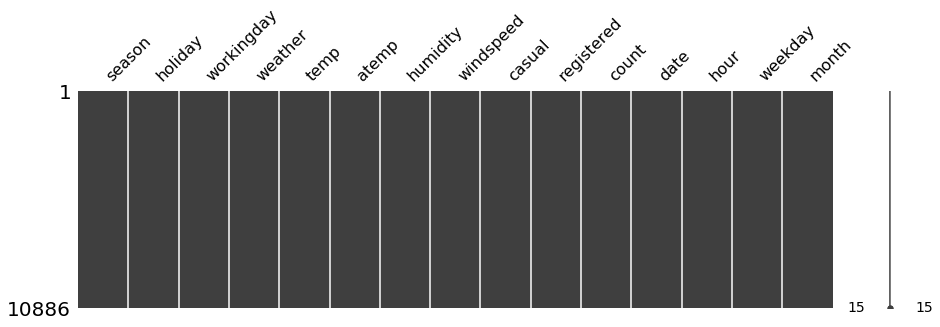

In [116]:
msno.matrix(dailyData, figsize = (15, 4))

## Outliers Analysis
At first look, "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit). But in addition to that, following inferences can also been made from the simple boxplots given below.

- Spring season has got relatively lower count. The dip in median value in boxplot gives evidence for it.
- The boxplot with "Hour Of The Day"is quiet interesting. The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that ti,e.
- Most of the outlier poins are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from figure4.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

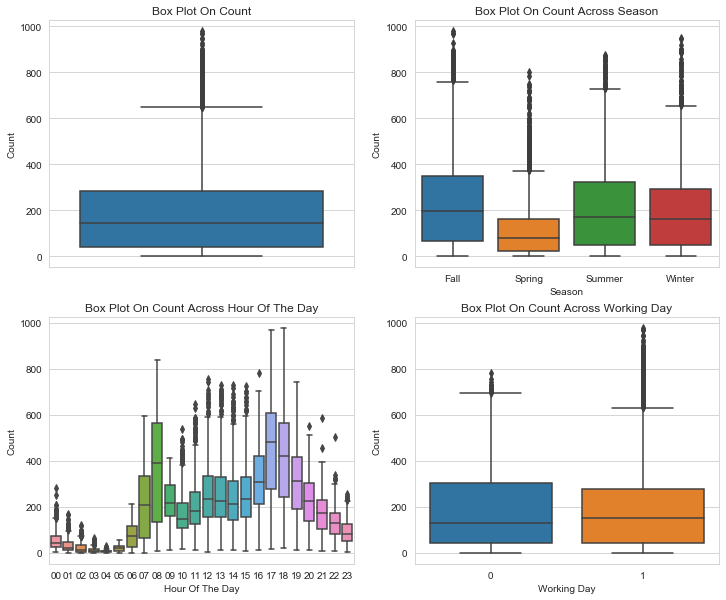

In [128]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(12, 10)
sn.set_style("whitegrid")

sn.boxplot(data = dailyData, y = "count", orient = "v", ax = axes[0][0])
sn.boxplot(data = dailyData, y = "count", x = "season", orient = "v", ax = axes[0][1])
sn.boxplot(data = dailyData, y = "count", x = "hour", orient = "v", ax = axes[1][0])
sn.boxplot(data = dailyData, y = "count", x = "workingday", orient = "v", ax = axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

**Lets Remove Outliers in The Count Column**

In [130]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3 * dailyData["count"].std())]

In [133]:
print ("Shape of The Before Outliers: ", dailyData.shape)
print ("Shape of The After Outliers: ", dailyDataWithoutOutliers.shape)

Shape of The Before Outliers:  (10886, 15)
Shape of The After Outliers:  (10739, 15)


## Correlation Analysis
One common to understand how a dependent variable is influenced by features (numerical) is to find a correlation matrix between them. Let's plot a correlation plot between "count" and ("temp", "atemp", "humidity", "windspeed").
- temp and humidity features has got positive and negative correlation with count respectively. Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".
- windspped is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
- "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
- "Casual" and "Registered" are also not taken into account since they are leakage variablesin nature and need to dropped during model building.

Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".

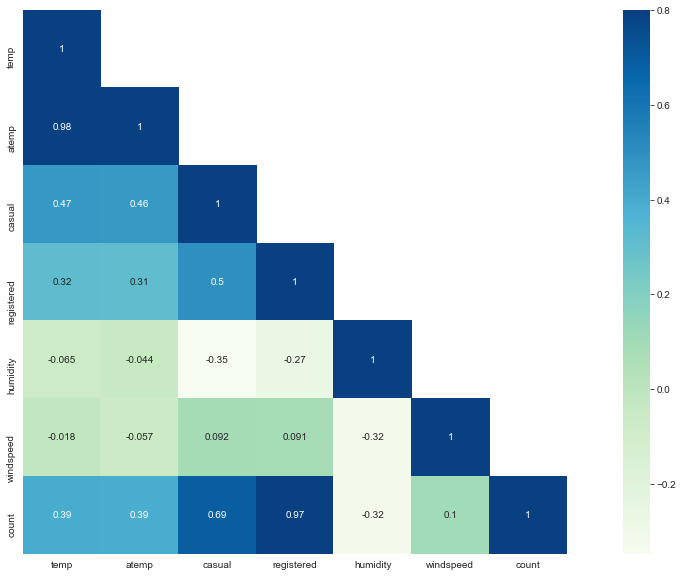

In [137]:
corrMatt = dailyData[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(20, 10)
sn.heatmap(corrMatt, mask = mask, vmax = .8, square = True, annot = True, cmap = "GnBu")

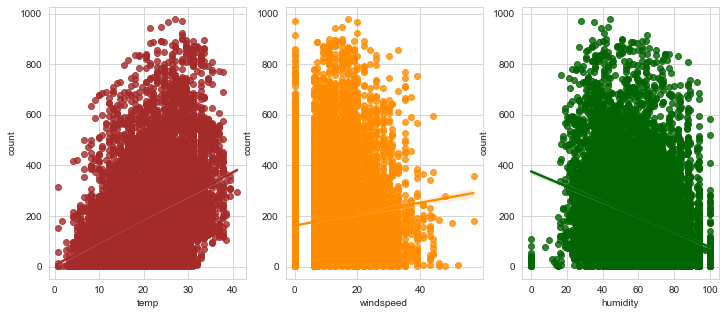

In [143]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(12, 5)
sn.regplot(x = "temp", y = "count", data = dailyData, ax = ax1, color = "brown")
sn.regplot(x = "windspeed", y = "count", data = dailyData, ax = ax2, color = "darkorange")
sn.regplot(x = "humidity", y = "count", data = dailyData, ax = ax3, color = "darkgreen")

## Visualizing Distribution Of Data
As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229774, 4.562423868087808, 0.9581176780909615))

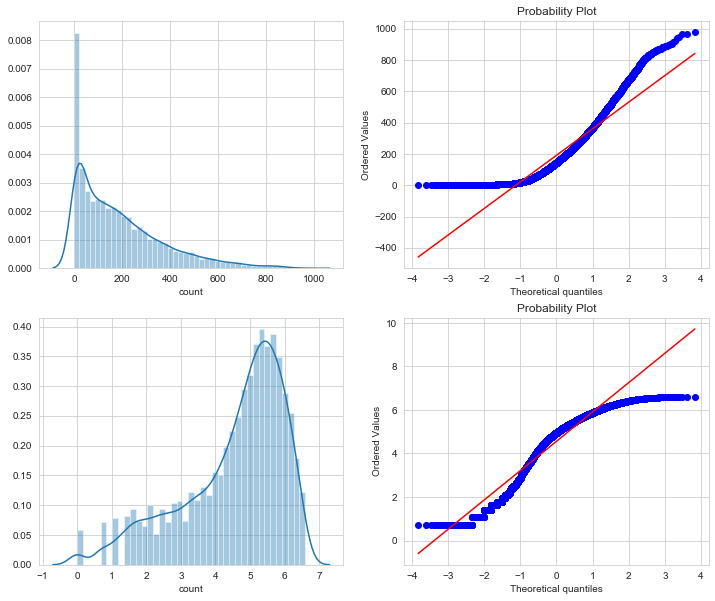

In [148]:
fig, axes = plt.subplots(ncols = 2, nrows = 2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"], ax = axes[0][0])
stats.probplot(dailyData["count"], dist = "norm", fit = True, plot = axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]), ax = axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist = "norm", fit = True, plot = axes[1][1])